In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '37c698f953ab48379ad95245eb0c26c6')
print(key)

37c698f953ab48379ad95245eb0c26c6


In [4]:
results = search_images_bing(key, 'ice cream')
results.attrgot('contentUrl')

(#150) ['https://i2.wp.com/thelittlepine.com/wp-content/uploads/2019/07/low-carb-chocolate-ice-cream1.jpg','https://www.tasteofhome.com/wp-content/uploads/2018/01/Chocolate-Crunch-Ice-Cream_exps31814_CW950599D43C_RMS.jpg','https://www.janespatisserie.com/wp-content/uploads/2019/07/IMG_1673_1.jpg','https://www-ketodiet.com/wp-content/uploads/2020/10/5a-keto-chocolate-ice-cream-square.jpg','https://feelgoodfoodie.net/wp-content/uploads/2019/07/Almond-Joy-Ice-Cream-12.jpg','https://cook.me/wp-content/uploads/2019/04/Five-Minute-Ice-Cream-How-to-Make-Homemade-Ice-Cream-in-5-Minutes-5-Min-Ice-Cream-Recipe-9.jpg','https://www.julieseatsandtreats.com/wp-content/uploads/2020/06/Rainbow-Ice-Cream-14-of-16.jpg','https://meet-thelocals.com/wp-content/uploads/2018/05/best-ice-creams-paris-summer-2018.jpg','http://lovingitvegan.com/wp-content/uploads/2016/09/Vegan-Chocolate-Ice-Cream-13.jpg','https://stressbaking.com/wp-content/uploads/2014/09/oreo-icecream-2.jpg'...]

In [5]:
var = "nick"
test_path = Path('test')
test_dest = (f'{test_path}/{var}')
print(test_dest)

test/nick


In [6]:
download_images(test_dest, urls=results.attrgot('contentUrl'))

In [7]:
files = get_image_files(test_path)
files

(#136) [Path('test/nick/00000047.jpg'),Path('test/nick/00000055.jpg'),Path('test/nick/00000107.jpg'),Path('test/nick/00000136.gif'),Path('test/nick/00000036.jpg'),Path('test/nick/00000097.jpg'),Path('test/nick/00000148.jpg'),Path('test/nick/00000029.jpg'),Path('test/nick/00000112.jpg'),Path('test/nick/00000091.jpg')...]

In [8]:
failed = verify_images(files)
failed

(#2) [Path('test/nick/00000045.jpg'),Path('test/nick/00000113.jpg')]

In [9]:
# remove the failed images
failed.map(Path.unlink)

(#2) [None,None]

In [10]:
# get the 3 bear classes into the current folder
bear_classes = ['polar', 'black', 'grizzly']
bear_path = Path('bear')

if not bear_path.exists():
    bear_path.mkdir()
for bear in bear_classes:
    # create the image destination
    bear_dest = (bear_path/bear)
    bear_dest.mkdir(exist_ok=True)
    bear_images = search_images_bing(key, f'{bear} bear')
    download_images(bear_dest, urls=bear_images.attrgot('contentUrl'))

In [11]:
bear_files = get_image_files(bear_path)
bear_files

(#426) [Path('bear/grizzly/00000047.jpg'),Path('bear/grizzly/00000055.jpg'),Path('bear/grizzly/00000107.jpg'),Path('bear/grizzly/00000036.jpg'),Path('bear/grizzly/00000030.jpg'),Path('bear/grizzly/00000097.jpg'),Path('bear/grizzly/00000029.jpg'),Path('bear/grizzly/00000093.jpg'),Path('bear/grizzly/00000090.jpg'),Path('bear/grizzly/00000147.jpg')...]

In [12]:
failed = verify_images(bear_files)
failed

(#5) [Path('bear/grizzly/00000056.jpg'),Path('bear/grizzly/00000019.jpg'),Path('bear/black/00000117.jpg'),Path('bear/polar/00000114.jpg'),Path('bear/polar/00000082.jpg')]

In [13]:
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

In [14]:
# now, create the bear data block
bear_db = DataBlock(
    # the types of X and y blocks, respectively
    blocks=(ImageBlock, CategoryBlock),
    # how to get the items; returns a list of item file locations
    get_items=get_image_files,
    # split the X
    splitter=RandomSplitter(valid_pct=0.25, seed=8),
    # how to get the y labels
    get_y = parent_label,
    # transform the image so that a tensor can have the same size images for the batch
    item_tfms=Resize(224)
)

In [15]:
dls = bear_db.dataloaders(bear_path)

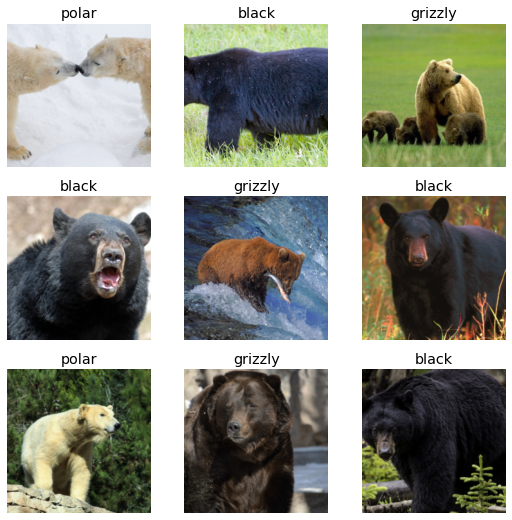

In [16]:
dls.valid.show_batch()

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


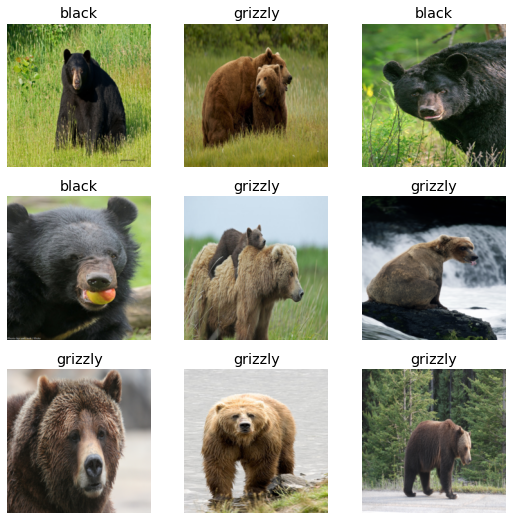

In [17]:
# test resizing with squish to fit
bear_db = bear_db.new(item_tfms=Resize(224, ResizeMethod.Squish))
dls = bear_db.dataloaders(bear_path)
dls.train.show_batch()

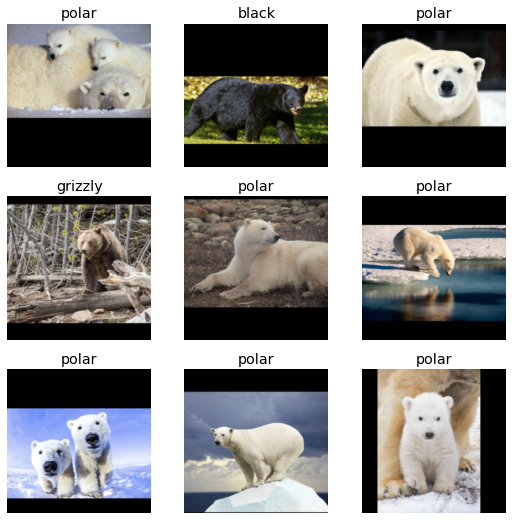

In [18]:
# try padding images with 0s
bear_db = bear_db.new(item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'))
dls = bear_db.dataloaders(bear_path)
dls.train.show_batch()

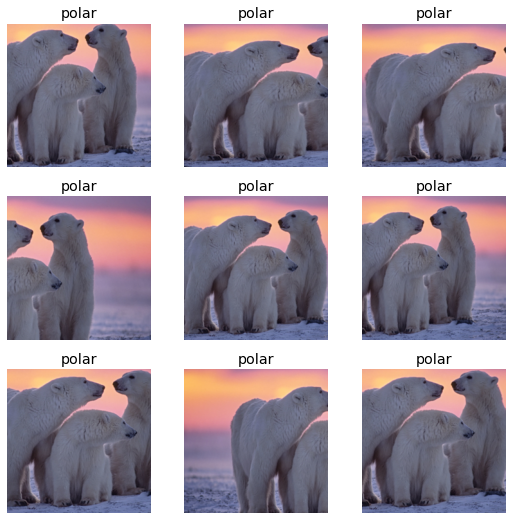

In [19]:
# best approach is to select different parts of the image on each epoch
# basic data augmentation below
bear_db = bear_db.new(item_tfms=RandomResizedCrop(224, min_scale=0.35))
dls = bear_db.dataloaders(bear_path)
dls.train.show_batch(unique=True)

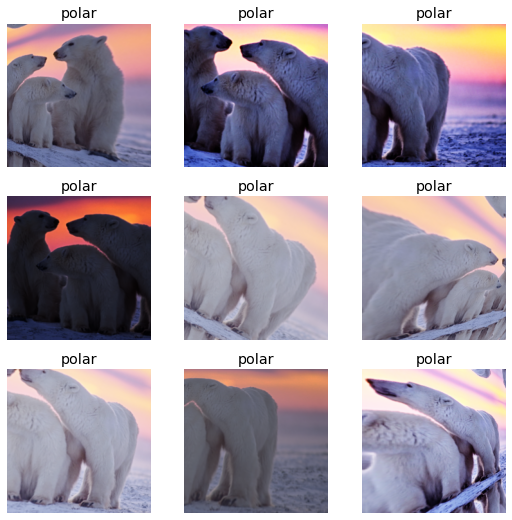

In [24]:
# perform more data augmentation using the batch_tfms function (which works since images are of the same size)
# data augmentation - creating random variations of input data s.t. they appear diff but do not change meaning of data
bear_aug = bear_db.new(item_tfms = Resize(224), batch_tfms=aug_transforms(mult=3))
dls = bear_aug.dataloaders(bear_path)
dls.train.show_batch(unique=True)

In [39]:
# make a final bear image data block

bears = bear_db.new(
    item_tfms = RandomResizedCrop(224, min_scale=0.4),
    batch_tfms = aug_transforms()
)
dls = bears.dataloaders(bear_path)

In [40]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.432929,0.979441,0.346154,00:13


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d08b26430>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/envs/fastai/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d08b26430>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/dat

epoch,train_loss,valid_loss,error_rate,time
0,0.281333,1.027711,0.317308,00:12
1,0.220760,1.037940,0.307692,00:13
2,0.173426,0.778554,0.221154,00:12
3,0.133649,0.702576,0.201923,00:11


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d08b26430>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/envs/fastai/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d08b26430>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/utils/dat

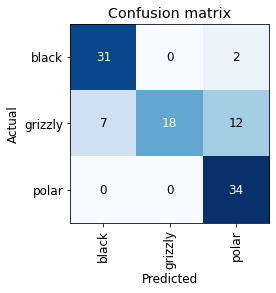

In [41]:
# create a confusion matrix to visualize the results
interpret_fails = ClassificationInterpretation.from_learner(learn)
interpret_fails.plot_confusion_matrix()

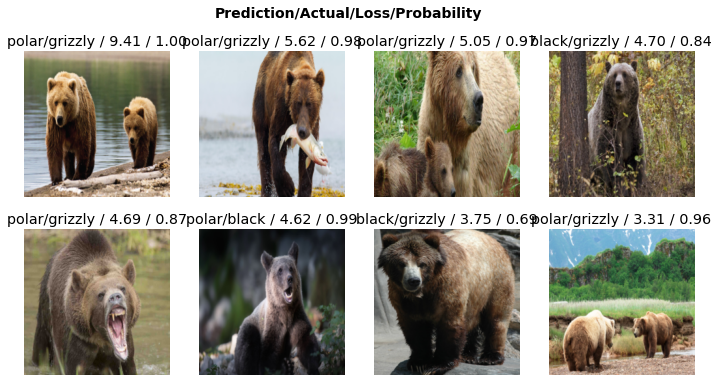

In [42]:
interpret_fails.plot_top_losses(8)

In [43]:
cleaner = ImageClassifierCleaner(learn)
cleaner


In [ ]:
for idx,cat in cleaner.change(): 
    print(cat)
    shutil.move(str(cleaner.fns[idx]), f'{bear_path}/{cat}/{idx+252}.jpg')

In [48]:
learn.export()

In [49]:
learn_path = Path()
learn_path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [50]:
learn_path

Path('.')